## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import torchvision
from torchvision.transforms import ToTensor, Resize, Grayscale, Compose, RandomHorizontalFlip, RandomVerticalFlip
import pandas as pd
from skimage import io, color
from functions import device, train_step, test_step, eval_model

In [18]:
# device = torch.device("cpu")

# Dataset and Dataloader

### Make dataset class

In [94]:
class Fish_dataset(Dataset):
    '''
    Transformer som standard til tensors.
    '''
    def __init__(self,csv_file,transform=None,gray = True):
        self.annotations = pd.read_csv(csv_file,delimiter=";",names = ["Path","Label"])
        self.transform = transform
        self.gray = gray
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        im_path = self.annotations.iloc[idx,0]
        image = io.imread(im_path)
        if self.gray:
            image = color.rgb2gray(image)
        if self.transform:
            image = self.transform(image).type(torch.float32)
        label = torch.tensor(self.annotations.iloc[idx,1]).type(torch.float32)

        return image,label

### Make train and test dataset

In [4]:
BATCH_SIZE = 32

fish_data = Fish_dataset(csv_file="fish_dataset.csv",gray=True,transform=Compose([ToTensor(),Resize((224,224),antialias=True)]))
train_data, test_data = random_split(fish_data,[0.8,0.2],generator=torch.Generator().manual_seed(42))

### Calculate weights for each class

In [5]:
train_targets = np.array([int(train_data[i][1]) for i in range(len(train_data))])
class_sample_count = np.unique(train_targets, return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = torch.tensor(([weight[t] for t in train_targets]))
sampler = WeightedRandomSampler(samples_weight, 2*len(samples_weight))

### Make train and test dataloader

In [6]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,sampler=sampler)
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)
print(f"{len(train_loader)} batches of {BATCH_SIZE} samples in training data")

33 batches of 32 samples in training data


### Visualize some data

(-0.5, 223.5, 223.5, -0.5)

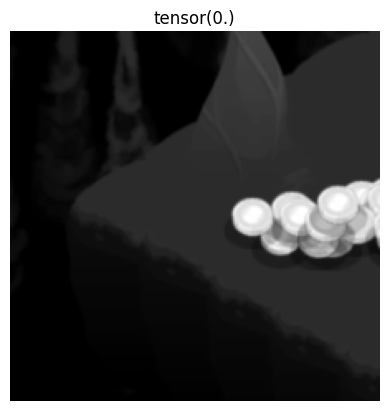

In [7]:
plt.imshow(train_data[0][0].permute(1,2,0),cmap="gray")
plt.title(train_data[0][1])
plt.axis(False)

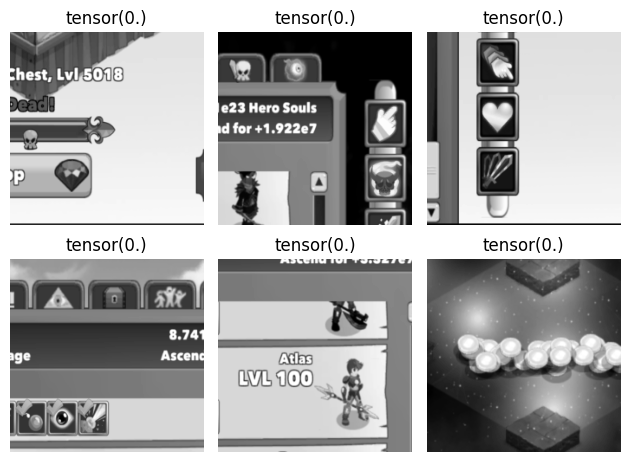

In [8]:
fig = plt.figure(tight_layout=True)
rows,cols = 2,3
for i in range(1,rows*cols+1):
    idx = np.random.randint(len(train_data))
    plt.subplot(rows,cols,i)
    plt.imshow(train_data[idx][0].permute(1,2,0),cmap="gray")
    plt.title(train_data[idx][1])
    plt.axis(False)
plt.show()

# First model

## create model

### Create model class

In [9]:
class Fish_Model_V0(nn.Module):
    def __init__(self,input_shape, hidden_units, output_shape):
        super().__init__()
        self.stack1 = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_shape,hidden_units),
                                    nn.ReLU(),
                                    nn.Linear(hidden_units,output_shape))
    def forward(self,x):
        return self.stack1(x)

### create model instance

In [10]:
model_0 = Fish_Model_V0(224*224,69,1).to(device)
model_0

Fish_Model_V0(
  (stack1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=69, bias=True)
    (2): Linear(in_features=69, out_features=1, bias=True)
  )
)

### Test model output with a random input

In [11]:
dummy_input = torch.rand(1,1,224,224).to(device)
F.sigmoid(model_0(dummy_input)).round(),dummy_input.dtype

(tensor([[1.]], device='mps:0', grad_fn=<RoundBackward0>), torch.float32)

### Loss and optimizer

In [12]:
LEARNING_RATE = 0.001
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=LEARNING_RATE)

## Train/Test model

In [13]:
from tqdm.auto import tqdm
NUM_EPOCHS = 3

train_loss_all = []
test_loss_all = []

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}")
    
    # Training
    model_0.train()
    train_loss = 0
    for batch,(X_train,y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # forward pass
        y_logits = model_0(X_train).squeeze()
        # calculate loss
        loss = loss_fn(y_logits,y_train)
        train_loss += loss
        # optimizer zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()
    train_loss /= len(train_loader)
    train_loss_all.append(train_loss.item())

    # Testing
    test_loss = 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # forward pass
            test_pred = model_0(X_test).squeeze()
            # calculate loss accumulating
            test_loss += loss_fn(test_pred,y_test)
        
        # calculate the average loss per batch
        test_loss /= len(test_loader)
        test_loss_all.append(test_loss.item())
    # Print out what is happening
    print(f"Train_loss: {train_loss:.4f} | Test_loss: {test_loss:.4f}")
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train_loss: 0.6730 | Test_loss: 0.7952

Epoch: 1
Train_loss: 0.6248 | Test_loss: 0.6467

Epoch: 2
Train_loss: 0.6056 | Test_loss: 0.8511



### Visualize model train/test loss

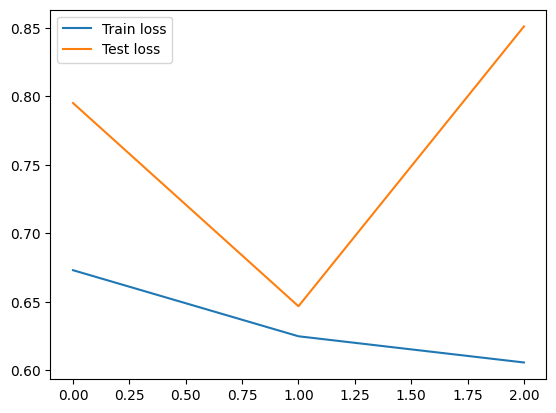

In [14]:
plt.plot(range(NUM_EPOCHS),train_loss_all,label="Train loss")
plt.plot(range(NUM_EPOCHS),test_loss_all,label="Test loss")
plt.legend()
plt.show()

## Model evaluation

In [16]:
y_preds_total, y_total,model_0_stats = eval_model(model_0,test_loader,loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0465
Accuracy: 0.3664
Confusion matrix: 
tensor([[36, 82],
        [ 1, 12]])


In [17]:
model_0_stats

{'Model Name': 'Fish_Model_V0',
 'loss': 1.0465116500854492,
 'accuracy': 0.3664122223854065,
 'confusion_matrix': tensor([[36, 82],
         [ 1, 12]])}

## Save model

In [18]:
# save model
torch.save(model_0.state_dict(),"model_0.pth")

# Second model

## create model

### Create model class

In [20]:
class Fish_Model_V1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.stack1 = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_shape,hidden_units),
                                    nn.ReLU(),
                                    nn.Linear(hidden_units,hidden_units),
                                    nn.ReLU(),
                                    nn.Linear(hidden_units,1))
        
    def forward(self, x):
        return self.stack1(x)

### Create model instance

In [21]:
model_1 = Fish_Model_V1(224*224,69,1).to(device)
model_1

Fish_Model_V1(
  (stack1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=69, bias=True)
    (2): ReLU()
    (3): Linear(in_features=69, out_features=69, bias=True)
    (4): ReLU()
    (5): Linear(in_features=69, out_features=1, bias=True)
  )
)

### Optimizer and loss

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr = LEARNING_RATE)

## Train/test loop

In [23]:
train_loss_all = []
test_loss_all = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}")
    # Train
    train_loss = train_step(model_1,train_loader,loss_fn,optimizer,device)
    train_loss_all.append(train_loss)

    # Test
    test_loss = test_step(model_1,test_loader,loss_fn,device)
    test_loss_all.append(test_loss)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.6873
Test loss: 0.6578
Epoch: 1
Train loss: 0.6745
Test loss: 0.6259
Epoch: 2
Train loss: 0.6668
Test loss: 0.6387


## eval model

In [24]:
model_1_stats = eval_model(model_1,test_loader,loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7518
Accuracy: 0.8092
Confusion matrix: 
tensor([[105,  13],
        [ 12,   1]])


## Save model

In [25]:
# save model
torch.save(model_1.state_dict(),"model_1.pth")

# Third model (CNN)

## Dataset and Dataloader

In [120]:
BATCH_SIZE = 32
data_transform = Compose([ToTensor(),
                          Resize((224,224),antialias=True),
                          RandomHorizontalFlip(p=0.5),
                          RandomVerticalFlip(p=0.5)])
fish_data = Fish_dataset(csv_file="fish_dataset.csv",gray=False,transform=data_transform)
train_data, test_data = random_split(fish_data,[0.8,0.2],generator=torch.Generator().manual_seed(42))

### Calculate weights for each class

In [121]:
train_targets = np.array([int(train_data[i][1]) for i in range(len(train_data))])
class_sample_count = np.unique(train_targets, return_counts=True)[1]
weight = 1. / class_sample_count
samples_weight = torch.tensor(([weight[t] for t in train_targets]))
sampler = WeightedRandomSampler(samples_weight, 2*len(samples_weight))

### Make train and test dataloader

In [137]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True) ## with shuffle
# train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,sampler=sampler) ## With sampler
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)
print(f"{len(train_loader)} batches of {BATCH_SIZE} samples in training data")

17 batches of 32 samples in training data


In [138]:
train_class_0_count = 0
train_class_1_count = 0

for _, labels in train_loader:
    train_class_0_count += (labels == 0).sum().item()
    train_class_1_count += (labels == 1).sum().item()

print("Train: Number of class 0:", train_class_0_count)
print("Train: Number of class 1:", train_class_1_count)

pos_weight = torch.tensor([train_class_0_count / train_class_1_count])
print("Positive weight:", pos_weight.item())

Train: Number of class 0: 502
Train: Number of class 1: 26
Positive weight: 19.30769157409668


In [139]:
test_class_0_count = 0
test_class_1_count = 0

for _, labels in test_loader:
    test_class_0_count += (labels == 0).sum().item()
    test_class_1_count += (labels == 1).sum().item()

print("Test: Number of class 0:", test_class_0_count)
print("Test: Number of class 1:", test_class_1_count)

Test: Number of class 0: 118
Test: Number of class 1: 13


### Visualize some data

(-0.5, 223.5, 223.5, -0.5)

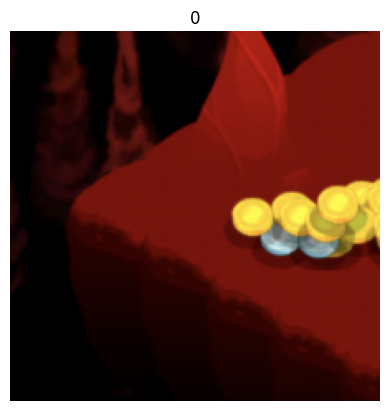

In [140]:
plt.imshow(train_data[0][0].permute(1,2,0),cmap="gray")
plt.title(int(train_data[0][1].item()))
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


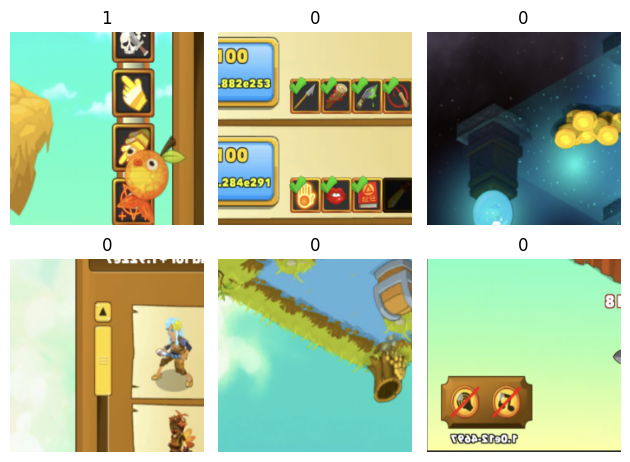

In [157]:
fig = plt.figure(tight_layout=True)
rows,cols = 2,3
for i in range(1,rows*cols+1):
    idx = np.random.randint(len(train_data))
    plt.subplot(rows,cols,i)
    plt.imshow(train_data[idx][0].permute(1,2,0),cmap="gray")
    plt.title(int(train_data[idx][1].item()))
    plt.axis(False)
plt.show()

## Create model

### Create model class

In [142]:
class Fish_Model_V2(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.stack1 = nn.Sequential(nn.Conv2d(input_shape,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),)
        
        self.stack2 = nn.Sequential(nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.classification = nn.Sequential(nn.Flatten(),
                                            nn.Linear(hidden_units*56*56,output_shape))
    
    def forward(self,x):
        x = self.stack1(x)
        # print(x.shape)
        x = self.stack2(x)
        # print(x.shape)
        x = self.classification(x)
        return x

### Create model instance

In [165]:
model_2 = Fish_Model_V2(3,10,1).to(device)

### Test model output with a random input

In [166]:
dummy_input = torch.rand(1,3,224,224).to(device)
dummy_input.device

device(type='mps', index=0)

In [167]:
model_2(dummy_input)

tensor([[-0.0248]], device='mps:0', grad_fn=<LinearBackward0>)

### Loss and optimizer

In [168]:
LEARNING_RATE = 0.01
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.SGD(model_2.parameters(),lr=LEARNING_RATE)

## Test/train model

In [170]:
from tqdm.auto import tqdm
NUM_EPOCHS = 10
train_loss_all = []
test_loss_all = []
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch}")
    # Train
    train_loss = train_step(model_2,train_loader,loss_fn,optimizer,device)
    train_loss_all.append(train_loss)

    # Test
    test_loss = test_step(model_2,test_loader,loss_fn,device)
    test_loss_all.append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.3021
Test loss: 1.7266
Epoch: 1


KeyboardInterrupt: 

## eval model

In [148]:
model_2_stats = eval_model(model_2,test_loader,loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7832
Accuracy: 0.0992
Confusion matrix: 
tensor([[  0, 118],
        [  0,  13]])


In [149]:
model_2_stats

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0